## Libraries

In [ ]:
!pip install kaggle

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from pickle import load

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

## Load Data

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it. ##
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

In [ ]:
!kaggle competitions download -c ventilator-pressure-prediction

In [ ]:
DEBUG = False

In [ ]:
train = pd.read_csv(r'../content/train.csv.zip')
test  = pd.read_csv(r'../content/test.csv.zip')
submission = pd.read_csv(r'../content/sample_submission.csv.zip')

In [ ]:
# train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
# test  = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
# submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [ ]:
if DEBUG:
    train = train[:80*1000]

In [ ]:
train.shape, test.shape, submission.shape

In [ ]:
train

In [ ]:
train.describe()

In [ ]:
# test['pressure'] = 0

In [ ]:
test

In [ ]:
test.describe()

## Add Feature

In [ ]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [ ]:
targets = train['pressure'].to_numpy().reshape(-1, 80)
train.drop(labels='pressure', axis=1, inplace=True)
train = add_features(train)
# normalise the dataset
RS = RobustScaler()
train = RS.fit_transform(train)

# Reshape to group 80 timesteps for each breath ID
train = train.reshape(-1, 80, train.shape[-1])

In [ ]:
test = add_features(test)
test = RS.transform(test)
test = test.reshape(-1, 80, test.shape[-1])

In [ ]:
train.shape, test.shape

## Model Creation

In [ ]:
# model creation
def create_lstm_model():

    x0 = tf.keras.layers.Input(shape=(train.shape[-2], train.shape[-1]))  

    lstm_layers = 4 # number of LSTM layers
    lstm_units = [320, 305, 304, 229]
    lstm = Bidirectional(keras.layers.LSTM(lstm_units[0], return_sequences=True))(x0)
    for i in range(lstm_layers-1):
        lstm = Bidirectional(keras.layers.LSTM(lstm_units[i+1], return_sequences=True))(lstm)    
    lstm = Dropout(0.001)(lstm)
    lstm = Dense(100, activation='relu')(lstm)
    lstm = Dense(1)(lstm)

    model = keras.Model(inputs=x0, outputs=lstm)
    model.compile(optimizer="adam", loss="mae")
    
    return model

## Training

In [ ]:
# Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    return tpu, strategy

tpu, strategy = get_hardware_strategy()

In [ ]:
EPOCH = 350
BATCH_SIZE = 512
NFOLDS = 5

with strategy.scope():
    kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=2021)
    history = []
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        model = create_lstm_model()
        model.compile(optimizer="adam", loss="mae", metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

        scheduler = ExponentialDecay(1e-3, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
        lr = LearningRateScheduler(scheduler, verbose=0)

        history.append(model.fit(X_train, y_train, 
                                 validation_data=(X_valid, y_valid), 
                                 epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr]))
        test_pred = model.predict(test).squeeze().reshape(-1, 1).squeeze()
        test_preds.append(test_pred)    
        
        # save model
        #model.save("lstm_model_fold_{}".format(fold))
        
        del X_train, X_valid, y_train, y_valid, model
        gc.collect()

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(16,16))
for i in range(NFOLDS):
    plt.plot(history[i].history['loss'], linestyle='-', color=colors[i], label='Train, fold #{}'.format(str(i)))
for i in range(NFOLDS):
    plt.plot(history[i].history['val_loss'], linestyle='--', color=colors[i], label='Validation, fold #{}'.format(str(i)))
plt.ylim(top=1)
plt.title('Model Loss')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(which='major', axis='both')
plt.show();

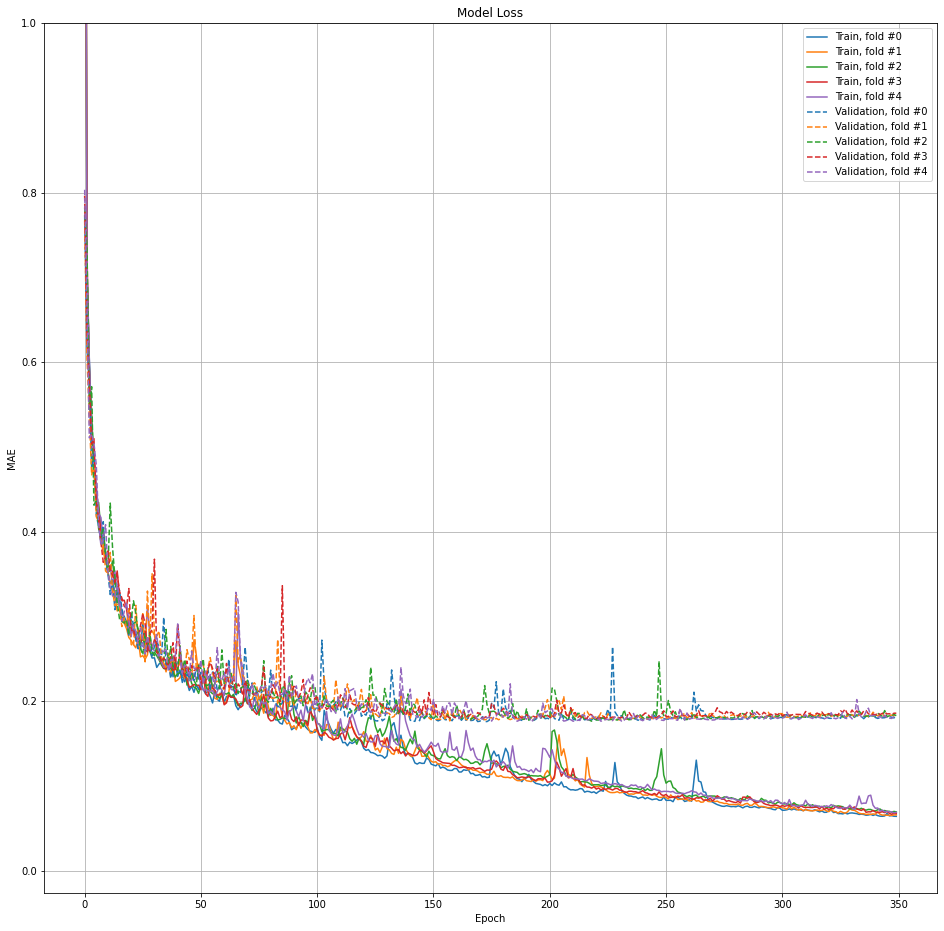

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = 'center')

fold_mae = np.zeros(NFOLDS, dtype=np.float)
for i in range(1):
    fold_mae[i] = history[i].history['val_loss'][-1]
plt.figure(figsize = (10, 5))
names = ['Fold #0', 'Fold #1', 'Fold #2', 'Fold #3', 'Fold #4']
plt.bar(names, fold_mae, color ='royalblue', width = 0.4)
addlabels(names, np.round(fold_mae, 3))
plt.ylabel("MAE")
plt.title("Fold scores")
plt.show();

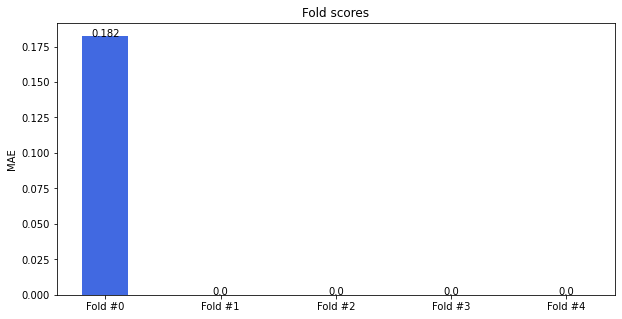

## Export && Submission

In [ ]:
submission["pressure"] = sum(test_preds)/5
submission.to_csv('submission.csv', index=False)
print('./submission.csv')

In [ ]:
submission

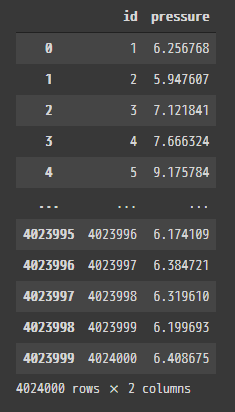

In [ ]:
!kaggle competitions submit -c ventilator-pressure-prediction -f submission.csv -m "Message"